In [198]:


import psycopg2
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import matplotlib
import warnings
import yellowbrick as yb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier

from yellowbrick.classifier import ClassificationReport

warnings.simplefilter(action='ignore', category=FutureWarning)

In [199]:
conn = psycopg2.connect( 
                        host = 'project.cgxhdwn5zb5t.us-east-1.rds.amazonaws.com',
                        port = 5432, 
                        user = 'postgres',
                        password = 'Admin123',
                        database = 'postgres')
cursor = conn.cursor()

In [200]:
DEC2FLOAT = psycopg2.extensions.new_type(
    psycopg2.extensions.DECIMAL.values,
    'DEC2FLOAT',
    lambda value, curs: float(value) if value is not None else None)
psycopg2.extensions.register_type(DEC2FLOAT)

In [201]:
cursor.execute('Select * from "ahshouseholdclass"')
rows = cursor.fetchall()
col_names = []
for elt in cursor.description:
    col_names.append(elt[0])

df = pd.DataFrame(data=rows, columns=col_names )

In [244]:
df = pd.read_csv('AHS Household Class.csv')

In [245]:
df.columns

Index(['Unnamed: 0', 'CONTROL', 'YEAR', 'RATINGHS_BIN', 'RATINGHS', 'STORIES',
       'UFINROOMS', 'BEDROOMS', 'HHOLDKIDS', 'KITCHENS', 'ELECAMT',
       'HHADLTKIDS', 'FINROOMS', 'NUMVETS', 'HHMOVE', 'NUMOLDKIDS', 'TRASHAMT',
       'WATERAMT', 'FINCP', 'BATHROOMS', 'NUMSUBFAM', 'NUMSECFAM', 'UNITSIZE',
       'NUMADULTS', 'HHYNGKIDS', 'UTILAMT', 'NUMELDERS', 'NUMYNGKIDS',
       'NUMPEOPLE', 'OTHERAMT', 'HINCP', 'PARTNER', 'PERPOVLVL', 'LOTSIZE',
       'TOTROOMS', 'HHAGE', 'LAUNDY', 'NUMNONREL', 'MULTIGEN', 'OILAMT',
       'GASAMT', 'DINING', 'LN_HINCP', 'LN_FINCP', 'HINCP_BIN', 'FINCP_BIN',
       'NUMERRND', 'OMB13CBSA', 'MVG1COST', 'HHRACE', 'NUMHEAR', 'NUMWALK',
       'MVG2COST', 'MVG3COST', 'HSHLDTYPE', 'FIREPLACE', 'NUMCARE', 'HHMAR',
       'HHNATVTY', 'BLD', 'NUMMEMRY', 'MILHH', 'COOKFUEL', 'DIVISION',
       'NUMSEE', 'HHCARE', 'CONDO', 'FRIDGE', 'HHMEMRY', 'HHWALK', 'HHHEAR',
       'NOSTEP', 'OWNLOT', 'WINBARS', 'KITCHSINK', 'GARAGE', 'HHSEE',
       'HHERRND', 'FIRSTHO

In [246]:
df['HINCP_BIN'].value_counts()

(40000.0, 50000.0]     2465
(30000.0, 40000.0]     2409
(20000.0, 30000.0]     2403
(50000.0, 60000.0]     2220
(60000.0, 70000.0]     2011
(10000.0, 20000.0]     2003
(70000.0, 80000.0]     1956
(80000.0, 90000.0]     1737
(90000.0, 100000.0]    1558
(0.0, 10000.0]         1346
Name: HINCP_BIN, dtype: int64

In [247]:
df['RATINGHS_BIN'].value_counts()

extremely satisfied    7021
satisfied              5284
not satisfied          4887
very satisfied         2916
Name: RATINGHS_BIN, dtype: int64

In [259]:
X = df[['PERPOVLVL', 'NUMELDERS','BEDROOMS','OMB13CBSA','ELECAMT','BATHROOMS', 'HHMOVE',
        'UTILAMT', 'DIVISION','UNITSIZE', 'HHNATVTY', 'HINCP_BIN','HHWALK', 'HHHEAR', 'HHSEX',
        'GARAGE', 'DISHWASH','DINING', 'LAUNDY']]

y = df['RATINGHS_BIN']


### Class Imbalanced

In [249]:
# Create the train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [250]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

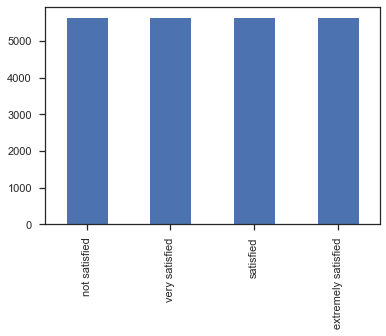

In [251]:
pd.Series(y_sm).value_counts().plot.bar()

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


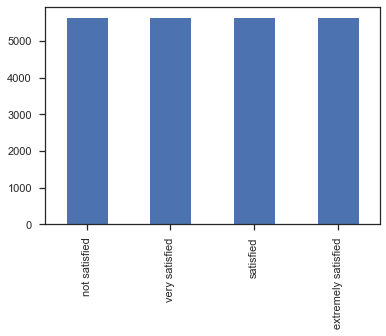

In [252]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar()

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


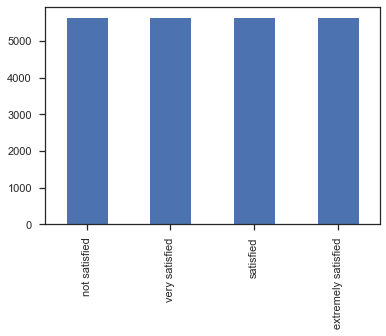

In [253]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar()

In [254]:
#X = df[['PERPOVLVL', 'BEDROOMS','TOTROOMS','BATHROOMS', 'HHMOVE', 'UTILAMT','HHNATVTY','HINCP','FINCP']]
#y = df[['RATINGHS_BIN']]

In [255]:
def score_model(X, y, estimator, **kwargs):
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])


    model.fit(X_train, y_train.values.ravel(), **kwargs)  
    
    expected  = y_test
    predicted = model.predict(X_test)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='micro')))

In [276]:
models = [
    SVC(), NuSVC(), LinearSVC(), 
    SGDClassifier(), KNeighborsClassifier(), 
    LogisticRegression(), 
    #aggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100,learning_rate=.3)
    #learning_rate=.5,max_depth=4, min_samples_leaf=75
]

for model in models:
    score_model(X_sm, y_sm.ravel(), model)

SVC: 0.347090999502735
NuSVC: 0.3142715067130781
LinearSVC: 0.3388861263053207
SGDClassifier: 0.3416210840377921
KNeighborsClassifier: 0.34733963202386875
LogisticRegression: 0.3508204873197414
ExtraTreesClassifier: 0.3856290402784685
RandomForestClassifier: 0.38662357036300343
GradientBoostingClassifier: 0.37667826951765293


## Classification Report

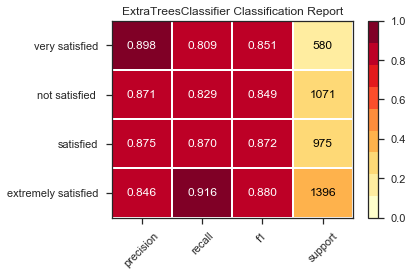

In [273]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
classes=['extremely satisfied','satisfied','not satisfied ','very satisfied']
model = ExtraTreesClassifier()
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_sm, y_sm.ravel())        # Fit the visualizer and the model
visualizer.score(X_test, y_test.values.ravel())        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

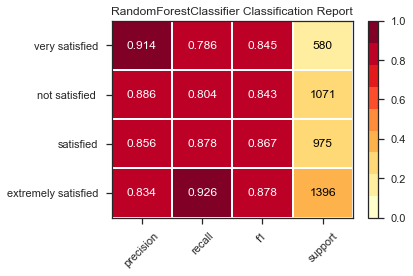

In [274]:

# Instantiate the classification model and visualizer
classes=['extremely satisfied','satisfied','not satisfied ','very satisfied']
model = RandomForestClassifier()
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_sm, y_sm.ravel())        # Fit the visualizer and the model
visualizer.score(X_test, y_test.values.ravel())        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

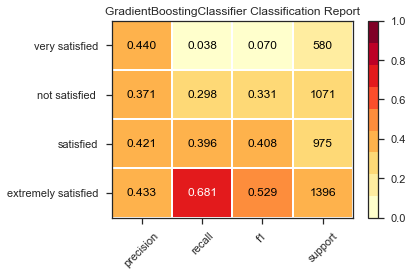

In [275]:
# Instantiate the classification model and visualizer
classes=['extremely satisfied','satisfied','not satisfied ','very satisfied']
model = GradientBoostingClassifier()
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_sm, y_sm.ravel())        # Fit the visualizer and the model
visualizer.score(X_test, y_test.values.ravel())        # Evaluate the model on the test data
visualizer.show()   

### Confusion Matrixs


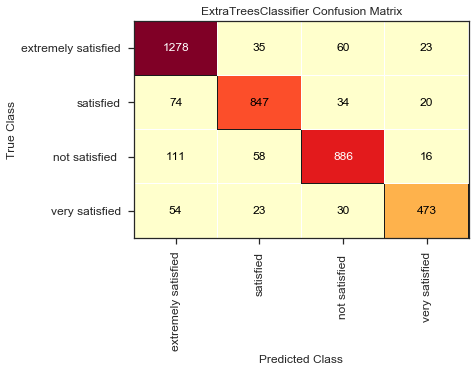

In [268]:
from yellowbrick.classifier import ConfusionMatrix
model = ExtraTreesClassifier()

cm = ConfusionMatrix(model, classes=['extremely satisfied','satisfied','not satisfied ','very satisfied'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_sm, y_sm.ravel())

cm.score(X_test, y_test.values.ravel())

cm.show()

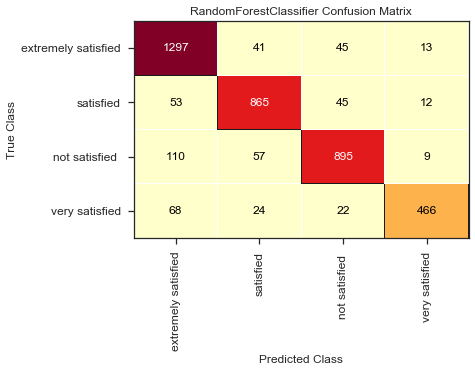

In [269]:
model = RandomForestClassifier(n_estimators=100)

cm = ConfusionMatrix(model, classes=['extremely satisfied','satisfied','not satisfied ','very satisfied'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_sm, y_sm.ravel())

cm.score(X_test, y_test.values.ravel())

cm.show()

### GridSearchCV

In [145]:
#X = df[['PERPOVLVL', 'NUMELDERS','BEDROOMS','OMB13CBSA','ELECAMT','BATHROOMS', 'HHMOVE',
        'UTILAMT', 'DIVISION','UNITSIZE', 'HHNATVTY','HINCP_BIN', 'HHHEAR', 'HHSEX',
        'GARAGE', 'DISHWASH','DINING', 'LAUNDY']]
#y = df['RATINGHS']
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2)

In [154]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [185]:

from sklearn.model_selection import GridSearchCV
model = RandomForestClassifier()

# TODO:  Create a dictionary with the Ridge parameter options
parameters = {'bootstrap': [True, False],
 'max_features': ['auto','sqrt' 'log2'],
 'n_estimators': [50,100],
 'random_state': [None, 2, 6, 7, 8],
 'oob_score': [True, False],
 'warm_start': [True, False]}

clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train, y_train)

print('If we change our parameters to: {}'.format(clf.best_params_))

KeyboardInterrupt: 